**타이타닉 우주선이 우주를 비행하다가 침몰 ... 승객이 튀어져 나가버렷는데 찾으러 가야하는 문제임.**

데이터 필드
- **PassengerID**: gggg_pp 승객 탑승아이디 출발 그룹으루 분류
- **HomePlanet**: 출발 지 행성 
- **CroySleep**: 냉동상태로 이동 여부  (????? 수면마취급인가? 뭐지???)
- **Cabin**: 승객이 객실 위치 Deck(아직 뭘 의미하는지 모름)/Num/Side(Side P or S 좌현 우현)\
- **Destination**: 목적지 승객이 내릴 장소
- **Age**
- **VIP**
- **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck**: 부가서비스 추가금액(우주선 좋은데?)
- **Name**: 이게 아무런 상관관계가 없어보이지만.. 낚시당할수도 있어 분석해야해
- **Transported**: 예측필드 승객이 튕겨나가 버렸는지 여부

In [ ]:
import pandas as pd
train_df = pd.read_csv('data/train.csv')
print(len(train_df))
null_columns = train_df.columns[train_df.isnull().any()].tolist()
# ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']
# train_df = train_df['HomePlanet'].fillna(0)

print(train_df['Cabin'].value_counts())

print(len(train_df[train_df['Cabin'].isnull()]))

8693
Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: count, Length: 6560, dtype: int64
199


In [2]:
# 우주타이타닉 문제
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

gender_df = pd.read_csv('data/names.csv')

train_df = pd.read_csv('data/train.csv')



test_y = pd.read_csv('data/test.csv')
# test_y['VIP'] = test_y['VIP'].astype(int)

tmp_train_df = train_df.drop(columns=['Transported'])


train_df[["Pass_gggg", 'Pass_pp']] = train_df['PassengerId'].str.split('_', expand=True).astype(int)
test_y[["Pass_gggg", 'Pass_pp']] = test_y['PassengerId'].str.split('_', expand=True).astype(int)
train_df["Family_Size"] = train_df.groupby("Pass_gggg")["PassengerId"].transform("count")
test_y["Family_Size"] = test_y.groupby("Pass_gggg")["PassengerId"].transform("count")

train_means = tmp_train_df.select_dtypes(include=['float64']).mean()  # 수치형 열 평균
train_modes = tmp_train_df.select_dtypes(exclude=['number']).mode().iloc[0]  # 범주형 열 최빈값
for col in train_means.index:
    test_y[col] = test_y[col].fillna(train_means[col])

for col in train_modes.index:
    test_y[col] = test_y[col].fillna(train_modes[col])

# 결측값 그냥 지우지말고 채우기!
""" 더 안좋아지네???
train_df['Age'] = train_df["Age"].fillna(train_df.Age.mean())
train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = train_df[['RoomService',
                                                                             'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)
train_df['Cabin'] = train_df['Cabin'].fillna('No_CabinDeck/No_CabinNum/No_CabinSide')
train_df['Name'] = train_df['Name'].fillna('unknown unknown')

for col in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']:
        # train_df[col] = train_df.groupby('PassengerGroup')[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
        # train_df[col] = train_df.groupby('CabinNum')[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))
        train_df[col] = train_df[col].fillna(train_df[col].mode()[0])
"""

# 이렇게하면 130개중 80 개 살림림
spend_condition = (train_df['CryoSleep'].isnull()) & (train_df['RoomService'] == 0) & (train_df['Spa'] == 0) & (train_df['ShoppingMall'] == 0) & (train_df['FoodCourt'] == 0) \
& (train_df['VRDeck'] == 0)
train_df.loc[spend_condition, 'CryoSleep'] = train_df.loc[spend_condition, 'CryoSleep'].fillna(True)


train_df['Deck'] = train_df['Cabin'].str.split('/').str[0]
train_df['Side'] = train_df['Cabin'].str.split('/').str[2]

#  HomePlanet 결측값 최빈값으로 약 170개 제거
dest_condition = (train_df['HomePlanet'].isnull()) & (train_df['Deck'] == 'A') | (train_df['Deck'] == 'B') | ( train_df['Deck'] == 'C')
train_df.loc[dest_condition, 'HomePlanet'] = train_df.loc[dest_condition, 'HomePlanet'].fillna('Europa')
dest_condition = (train_df['HomePlanet'].isnull()) & ((train_df['Deck'] == 'F'))
train_df.loc[dest_condition, 'HomePlanet'] = train_df.loc[dest_condition, 'HomePlanet'].fillna('Earth')
dest_condition = (train_df['HomePlanet'].isnull()) & ((train_df['Deck'] == 'G'))
train_df.loc[dest_condition, 'HomePlanet'] = train_df.loc[dest_condition, 'HomePlanet'].fillna('Mars')

# 음 ... 
train_df['HomePlanet'] = train_df.groupby('Pass_gggg')['HomePlanet'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Earth')
)

train_df['CryoSleep'] = train_df.groupby('Deck')['CryoSleep'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else False)
)

test_y.loc[spend_condition, 'CryoSleep'] = test_y.loc[spend_condition, 'CryoSleep'].fillna(True)
test_y.loc[dest_condition, 'HomePlanet'] = test_y.loc[dest_condition, 'HomePlanet'].fillna('Europa')
# spend_threshold = train_df['Total_Spend'].quantile(0.1)
# cryo_condition = (train_df['CryoSleep'].isnull()) & (train_df['Total_Spend'] <= spend_threshold)
# train_df.loc[cryo_condition, 'CryoSleep'] = True

def fill_missing_values(df):
    # CryoSleep: 소비가 0이면 True
    spend_condition = (df['CryoSleep'].isnull()) & (df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1) == 0)
    df.loc[spend_condition, 'CryoSleep'] = True
    
    # HomePlanet: Deck 기반 채우기
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    for deck, planet in [('A', 'Europa'), ('B', 'Europa'), ('C', 'Europa'), ('F', 'Earth'), ('G', 'Mars')]:
        df.loc[df['HomePlanet'].isnull() & (df['Deck'] == deck), 'HomePlanet'] = planet
    # 나머지는 Pass_gggg 그룹으로
    df['HomePlanet'] = df.groupby('Pass_gggg')['HomePlanet'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Earth')
    )
    
    # 숫자형 결측치: KNNImputer
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    imputer = KNNImputer(n_neighbors=5)
    df[numeric_cols] = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols, index=df.index)
    
    # 나머지 범주형: 최빈값
    for col in ['Destination', 'VIP']:
        df[col] = df[col].fillna(df[col].mode()[0])
    df['Cabin'] = df['Cabin'].fillna('F/0/S')  # 기본값
    return df

train_df = fill_missing_values(train_df)
test_y = fill_missing_values(test_y)

numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
imputer = KNNImputer(n_neighbors=5)
train_df[numeric_cols] = pd.DataFrame(
    imputer.fit_transform(train_df[numeric_cols]), 
    columns=numeric_cols, 
    index=train_df.index
)

train_df['Age'] = train_df.groupby('Family_Size')['Age'].transform(
    lambda x: x.fillna(x.mean())
)

train_df = train_df.dropna()


train_df['HomePlanet'] = train_df['HomePlanet'].astype('category')
train_df['HomePlanet'] = train_df['HomePlanet'].cat.codes

train_df['Destination'] = train_df['Destination'].astype('category')
train_df['Destination'] = train_df['Destination'].cat.codes

train_df['Side'] = train_df['Side'].astype('category')
train_df['Side'] = train_df['Side'].cat.codes

train_df['Deck'] = train_df['Deck'].astype('category')
train_df['Deck'] = train_df['Deck'].cat.codes

train_df['SideDeck'] = train_df['Deck'] + train_df['Side']
train_df['SideDeck'] = train_df['SideDeck'].astype('category')
train_df['SideDeck'] = train_df['SideDeck'].cat.codes

train_df['VIP'] = train_df['VIP'].astype(int)
train_df['Transported'] = train_df['Transported'].astype(int)
train_df['CryoSleep'] = train_df['CryoSleep'].astype(int)

train_df['Cabin_Num'] = pd.to_numeric(train_df['Cabin'].str.split('/').str[1], errors='coerce')
train_df['Cabin_Num_bin'] = pd.qcut(train_df['Cabin_Num'], q=5, duplicates='drop')


luxury_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train_df['Total_Spend'] = train_df[luxury_cols].sum(axis=1)
train_df['Spend_Ratio'] = train_df['Total_Spend'] / (train_df['Age'] + 1)  # 0 나누기 방지


test_y['Total_Spend'] = test_y[luxury_cols].sum(axis=1)
test_y['Spend_Ratio'] = test_y['Total_Spend'] / (test_y['Age'] + 1)

test_y['Cabin_Num'] = pd.to_numeric(test_y['Cabin'].str.split('/').str[1], errors='coerce')
test_y['Cabin_Num_bin'] = pd.qcut(test_y['Cabin_Num'], q=5, duplicates='drop')

test_y['Deck'] = test_y['Cabin'].str.split('/').str[0]
test_y['Side'] = test_y['Cabin'].str.split('/').str[2]

test_y['HomePlanet'] = test_y['HomePlanet'].astype('category')
test_y['HomePlanet'] = test_y['HomePlanet'].cat.codes

test_y['Destination'] = test_y['Destination'].astype('category')
test_y['Destination'] = test_y['Destination'].cat.codes

test_y['Side'] = test_y['Side'].astype('category')
test_y['Side'] = test_y['Side'].cat.codes

test_y['Deck'] = test_y['Deck'].astype('category')
test_y['Deck'] = test_y['Deck'].cat.codes

test_y['SideDeck'] = test_y['Deck'] + test_y['Side']
test_y['SideDeck'] = test_y['SideDeck'].astype('category')
test_y['SideDeck'] = test_y['SideDeck'].cat.codes

test_y['VIP'] = test_y['VIP'].astype(int)
test_y['CryoSleep'] = test_y['CryoSleep'].astype(int)

# 로그 변환 적용
train_df['Total_Spend'] = train_df['Total_Spend'].apply(lambda x: np.log1p(x))
train_df['Spend_Ratio'] = train_df['Spend_Ratio'].apply(lambda x: np.log1p(x))

test_y['Total_Spend'] = test_y['Total_Spend'].apply(lambda x: np.log1p(x))
test_y['Spend_Ratio'] = test_y['Spend_Ratio'].apply(lambda x: np.log1p(x))



for col in luxury_cols:
    train_df[col + "_Ratio"] = train_df[col] / (train_df["Total_Spend"] + 1)
    test_y[col + "_Ratio"] = test_y[col] / (test_y["Total_Spend"] + 1)


train_df["Luxury_Spender"] = (train_df["Total_Spend"] > train_df["Total_Spend"].median()).astype(int)
test_y["Luxury_Spender"] = (test_y["Total_Spend"] > test_y["Total_Spend"].median()).astype(int)

# 혼자 온 손님 분류
train_df["Is_Alone"] = (train_df["Family_Size"] == 1).astype(int)
test_y["Is_Alone"] = (test_y["Family_Size"] == 1).astype(int)

# 나이 군집화
train_df["Age_Group"] = pd.cut(train_df["Age"], bins=[0, 12, 18, 30, 50, 100], labels=[0, 1, 2, 3, 4])
test_y["Age_Group"] = pd.cut(test_y["Age"], bins=[0, 12, 18, 30, 50, 100], labels=[0, 1, 2, 3, 4])

# 손님 비율
train_df["Spend_Per_Person"] = train_df["Total_Spend"] / (train_df["Family_Size"] + 1)
test_y["Spend_Per_Person"] = test_y["Total_Spend"] / (test_y["Family_Size"] + 1)

# 극단 값 제거
train_df["Total_Spend"] = np.clip(train_df["Total_Spend"], 0, train_df["Total_Spend"].quantile(0.99))
test_y["Total_Spend"] = np.clip(test_y["Total_Spend"], 0, test_y["Total_Spend"].quantile(0.99))


# 토론 뒤지다가 젠더 찾음
train_df['FirstName'] = train_df['Name'].str.split(' ').str.get(0)
train_df['LastName'] = train_df['Name'].str.split(' ').str.get(1)

test_y['FirstName'] = test_y['Name'].str.split(' ').str.get(0)
test_y['LastName'] = test_y['Name'].str.split(' ').str.get(1)

train_df = train_df.merge(gender_df[['FirstName', 'Gender']], on='FirstName', how='left')
train_df['Gender'] = train_df['Gender'].astype('category').cat.codes

test_y = test_y.merge(gender_df[['FirstName', 'Gender']], on='FirstName', how='left')
test_y['Gender'] = test_y['Gender'].astype('category').cat.codes


/tmp/ipykernel_129264/388602026.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_y[col] = test_y[col].fillna(train_modes[col])
/tmp/ipykernel_129264/388602026.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.loc[spend_condition, 'CryoSleep'] = train_df.loc[spend_condition, 'CryoSleep'].fillna(True)
/tmp/ipykernel_129264/388602026.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future beh

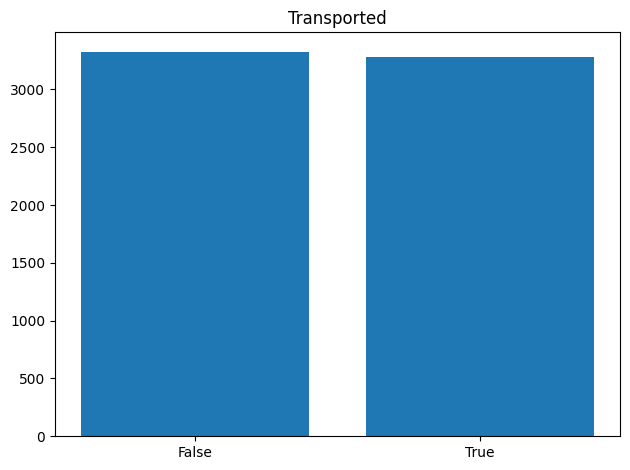

In [ ]:
# 데이터 분석!
import matplotlib.pyplot as plt

transport_df = train_df[train_df['Transported'] == False]
# 생존자 비율~
fig, ax = plt.subplots(1, 1)
ax.set_title("Transported")
ax.bar(['False', 'True'], train_df['Transported'].value_counts())

plt.tight_layout()
plt.show()


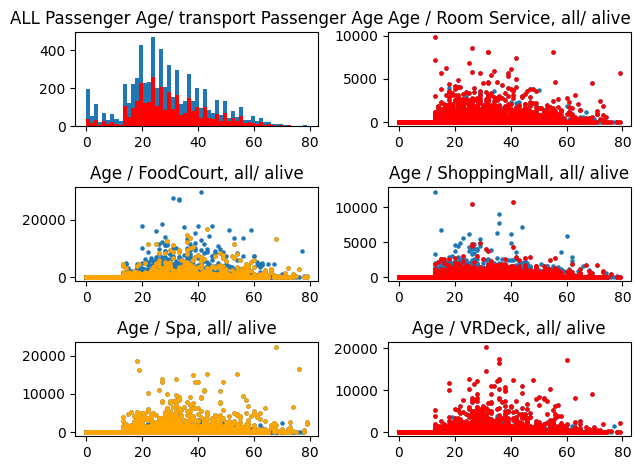

In [ ]:
# 나이 상관관계 분석
fig, ax = plt.subplots(3, 2)

ax[0][0].hist(train_df['Age'], bins=55, label='ALL Passenger Age')
ax[0][0].set_title("ALL Passenger Age/ transport Passenger Age")
ax[0][0].hist(transport_df['Age'], bins=55, color='red', label='transport Passenger Age')

ax[0][1].scatter(train_df['Age'], train_df['RoomService'], s=5)
ax[0][1].scatter(transport_df['Age'], transport_df['RoomService'], color='red', s=5)
ax[0][1].set_title("Age / Room Service, all/ alive")

ax[1][0].scatter(train_df['Age'], train_df['FoodCourt'], s=5)
ax[1][0].scatter(transport_df['Age'], transport_df['FoodCourt'], color='orange', s=5)
ax[1][0].set_title("Age / FoodCourt, all/ alive")

ax[1][1].scatter(train_df['Age'], train_df['ShoppingMall'], s=5)
ax[1][1].scatter(transport_df['Age'], transport_df['ShoppingMall'], s=5, color='red')
ax[1][1].set_title("Age / ShoppingMall, all/ alive")

ax[2][0].scatter(train_df['Age'], train_df['Spa'], s=5)
ax[2][0].scatter(transport_df['Age'], transport_df['Spa'], s=5, color='orange')
ax[2][0].set_title("Age / Spa, all/ alive")

ax[2][1].scatter(train_df['Age'], train_df['VRDeck'], s=5)
ax[2][1].scatter(transport_df['Age'], transport_df['VRDeck'], s=5, color='red')
ax[2][1].set_title("Age / VRDeck, all/ alive")

plt.tight_layout()
plt.show()

162 102


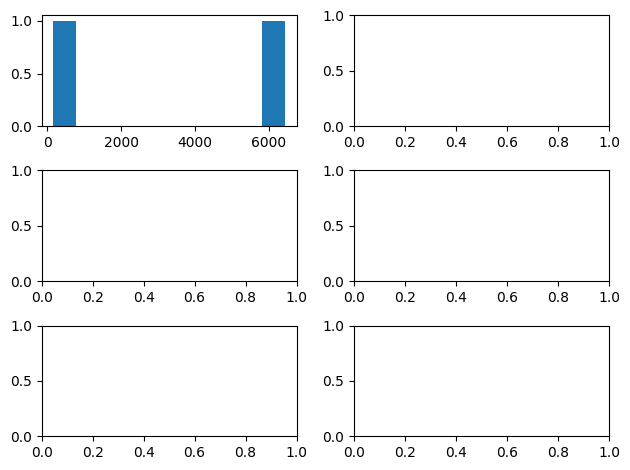

In [ ]:
# VIP 상관관계 분석
print(len(train_df[train_df['VIP']==True]), len(transport_df[transport_df['VIP'] == True]))
fig, ax = plt.subplots(3, 2)

ax[0][0].hist(train_df['VIP'].value_counts())


plt.tight_layout()
plt.show()

In [ ]:
df = train_df.select_dtypes(include=['number'])
df['Transported'] = train_df['Transported'].astype(int)
df['CryoSleep'] = train_df['CryoSleep'].astype(int)

print('------------------------------------------')
print(df.corr()['Transported'].sort_values(key=lambda x: x.abs()))

------------------------------------------
ShoppingMall_Ratio    0.010128
ShoppingMall          0.011602
Pass_gggg             0.023216
VIP                  -0.042260
Cabin_Num            -0.046766
FoodCourt             0.055025
FoodCourt_Ratio       0.058026
Pass_pp               0.075980
Gender                0.079823
SideDeck             -0.080749
Age                  -0.082553
Family_Size           0.086274
Side                  0.106186
HomePlanet            0.111806
Deck                 -0.112588
Is_Alone             -0.113186
Destination          -0.123773
VRDeck               -0.207950
Spa                  -0.219854
VRDeck_Ratio         -0.223897
Spa_Ratio            -0.238257
RoomService          -0.247291
RoomService_Ratio    -0.263098
Luxury_Spender       -0.398430
Spend_Per_Person     -0.431822
Spend_Ratio          -0.443847
CryoSleep             0.462803
Total_Spend          -0.463921
Transported           1.000000
Name: Transported, dtype: float64


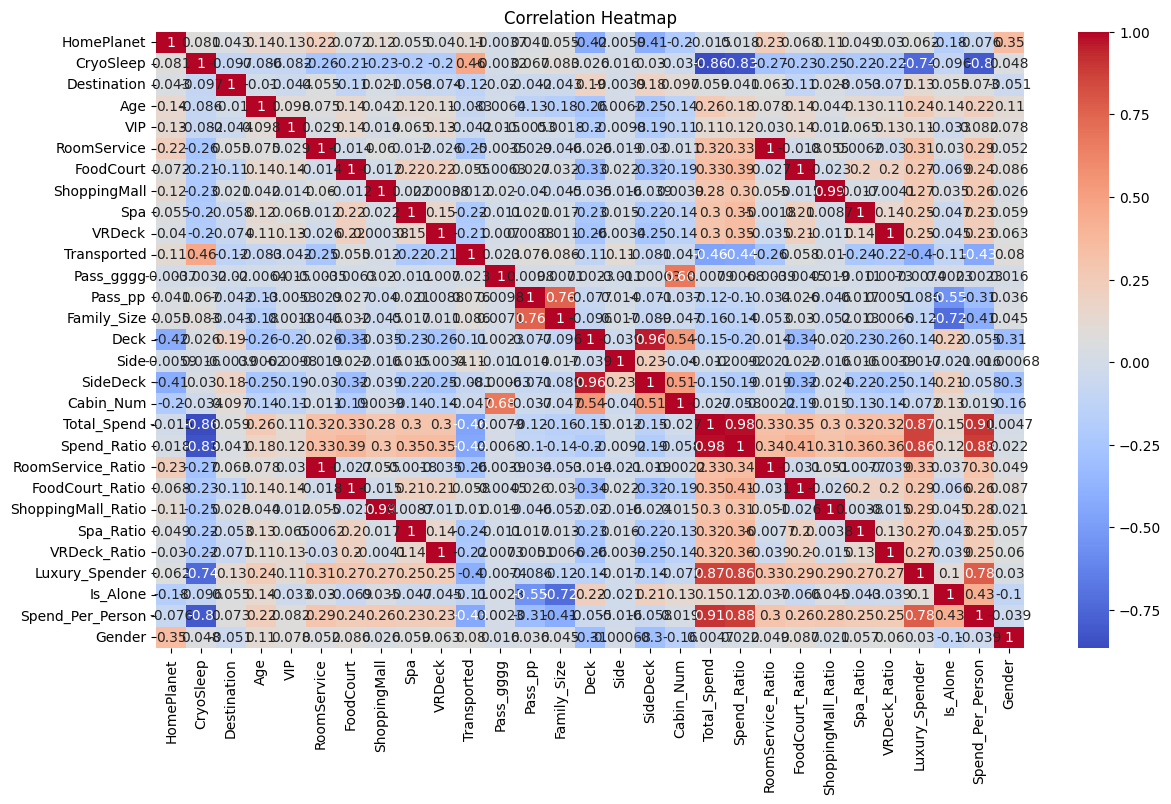

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 8)

corr_matrix = df.corr()

# print(corr_matrix.loc[corr_matrix['Transported'].abs() >= 0.1].index.tolist())
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### 상관 관계 도출.
- ShoppingMall    0.011602
- FoodCourt       0.055025
- Age            -0.082553
- Side            0.106186
- HomePlanet      0.111806
- CabDeckin      -0.112588
- Destination    -0.123773
- VRDeck         -0.207950
- Spa            -0.219854
- RoomService    -0.247291
- CryoSleep       0.462803
- Transported     1.000000

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 결정트리 분류류
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"결정트리 분류 정확도: {accuracy_score(y_pred, y_test)}")

결정트리 분류 정확도: 0.7397094430992736


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 랜덤 포레스트 분류류
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"랜덤포레스트 정확도: {accuracy_score(y_pred, y_test)}")

랜덤포레스트 정확도: 0.8020581113801453


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb


# 랜덤 포레스트 분류
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])


model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Xgb Boost 분류 정확도: {accuracy_score(y_pred, y_test)}")


Xgb Boost 분류 정확도: 0.8038740920096852


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier


# "cat Boost
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])


model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=100)


X_train, X_test, y_train, y_test = train_test_split(X, y)

model.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.get_feature_importance()
})
print(feature_importance)
low_importance = feature_importance[feature_importance['Importance'] < 5]['Feature'].tolist()
print(low_importance)
y_pred = model.predict(X_test)

print(f"cat Boost 분류 정확도: {accuracy_score(y_pred, y_test)}")

0:	learn: 0.6713537	total: 81.2ms	remaining: 40.5s
100:	learn: 0.3665560	total: 231ms	remaining: 912ms
200:	learn: 0.3189987	total: 375ms	remaining: 559ms
300:	learn: 0.2825701	total: 521ms	remaining: 344ms
400:	learn: 0.2545987	total: 659ms	remaining: 163ms
499:	learn: 0.2313179	total: 802ms	remaining: 0us
               Feature  Importance
0           HomePlanet    8.973705
1            CryoSleep    2.906262
2          Destination    2.332111
3                  Age    5.101012
4                  VIP    0.022114
5          RoomService    2.038393
6            FoodCourt    3.334998
7         ShoppingMall    1.858882
8                  Spa    3.507875
9               VRDeck    3.390431
10           Pass_gggg    4.536942
11             Pass_pp    0.725302
12         Family_Size    0.850948
13                Deck    7.112576
14                Side    3.600529
15            SideDeck    6.318024
16           Cabin_Num    7.077617
17         Total_Spend    7.758242
18         Spend_Ratio    

In [ ]:
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

class ML_Model:
    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=1)

        self.desiciontree = DecisionTreeClassifier()
        self.randomforest = RandomForestClassifier()
        self.xgboost = xgb.XGBClassifier(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        self.cat_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=100)

    def train(self):    
        self.desiciontree.fit(self.X_train, self.y_train)
        self.randomforest.fit(self.X_train, self.y_train)
        self.xgboost.fit(self.X_train, self.y_train)
        self.cat_model.fit(self.X_train, self.y_train)


        self.dtree_y_pred = self.desiciontree.predict(self.X_test)
        self.randomforest_y_pred = self.randomforest.predict(self.X_test)
        self.xgboost_y_pred = self.xgboost.predict(self.X_test)
        self.catboost_y_pred = self.cat_model.predict(self.X_test)
    
    def evaluate(self):
        
        pred_list = [self.dtree_y_pred, self.randomforest_y_pred,
                     self.xgboost_y_pred, self.catboost_y_pred]
        best_score = 0
        best_idnex = 0
        for index, pred in enumerate(pred_list):

            score = cross_val_score(self.y_test, pred)
            if score > best_score:
                best_idnex = index
                best_score = score
                

            print(f"정확도: {cross_val_score(self.y_test, pred)}")
        print(f'최고 정확도: {best_score}, 최고 모델: {best_idnex}')

In [ ]:

X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])
X_reduced = X.drop(columns=low_importance)

ml_model = ML_Model(X_reduced, y)
ml_model.train()
ml_model.evaluate()

0:	learn: 0.6728966	total: 1.26ms	remaining: 627ms
100:	learn: 0.4718862	total: 121ms	remaining: 480ms
200:	learn: 0.4425188	total: 233ms	remaining: 347ms
300:	learn: 0.4135400	total: 346ms	remaining: 229ms
400:	learn: 0.3903652	total: 458ms	remaining: 113ms
499:	learn: 0.3715063	total: 569ms	remaining: 0us


InvalidParameterError: The 'estimator' parameter of cross_val_score must be an object implementing 'fit'. Got 4249    0
6249    0
961     0
2418    1
3463    0
       ..
959     0
5514    0
5455    1
434     1
4032    1
Name: Transported, Length: 1652, dtype: int64 instead.

In [ ]:
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.get_feature_importance()
})
print(feature_importance)
low_importance = feature_importance[feature_importance['Importance'] < 5]['Feature'].tolist()
print(low_importance)
X_reduced = X.drop(columns=low_importance)

# test_y = pd.read_csv('data/test.csv')
test_y = test_y.select_dtypes(include=['number'])

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y)

model = ml_model.cat_model
model.fit(X_train, y_train)

y_pred = model.predict(test_y)
print(y_pred)
# print(f"랜덤포레스트 정확도: {accuracy_score(y_pred, y_test)}")

               Feature  Importance
0           HomePlanet    8.973705
1            CryoSleep    2.906262
2          Destination    2.332111
3                  Age    5.101012
4                  VIP    0.022114
5          RoomService    2.038393
6            FoodCourt    3.334998
7         ShoppingMall    1.858882
8                  Spa    3.507875
9               VRDeck    3.390431
10           Pass_gggg    4.536942
11             Pass_pp    0.725302
12         Family_Size    0.850948
13                Deck    7.112576
14                Side    3.600529
15            SideDeck    6.318024
16           Cabin_Num    7.077617
17         Total_Spend    7.758242
18         Spend_Ratio    3.816505
19   RoomService_Ratio    2.881907
20     FoodCourt_Ratio    4.023410
21  ShoppingMall_Ratio    2.644778
22           Spa_Ratio    4.829840
23        VRDeck_Ratio    4.076014
24      Luxury_Spender    0.878659
25            Is_Alone    0.105772
26    Spend_Per_Person    4.151926
27              Gend

In [ ]:
template_df = pd.read_csv('data/test.csv')
dd = template_df['PassengerId']

# int(dd)
ddf = pd.Series(y_pred, name='Transported')
ddf = ddf.map({1: 'True', 0: 'False'})
ds = pd.concat([dd ,ddf], axis=1)
print(ds)
ds.to_csv("result.csv", index=False)

     PassengerId Transported
0        0013_01        True
1        0018_01        True
2        0019_01        True
3        0021_01       False
4        0023_01       False
...          ...         ...
4272     9266_02        True
4273     9269_01       False
4274     9271_01        True
4275     9273_01       False
4276     9277_01        True

[4277 rows x 2 columns]


In [ ]:
from optuna import create_study
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    iterations = trial.suggest_int('iterations', 100, 1000)
    
    model = CatBoostClassifier(
        depth=depth, learning_rate=learning_rate, iterations=iterations, verbose=0
    )
    
    score = cross_val_score(model, X, y, cv=5, scoring="accuracy").mean()
    return score

study = create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)


/mnt/d/workspace/TIL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-25 11:03:49,539] A new study created in memory with name: no-name-fdf8a8db-884f-4251-9429-b4a269a31254
[W 2025-03-25 11:04:02,775] Trial 0 failed with parameters: {'depth': 9, 'learning_rate': 0.03669877530684092, 'iterations': 834} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/mnt/d/workspace/TIL/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_19636/3260889454.py", line 14, in objective
    score = cross_val_score(model, X, y, cv=5, scoring="accuracy").mean()
  File "/mnt/d/workspace/TIL/.venv/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 216, in 

KeyboardInterrupt: 

In [ ]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
# 자연빵 0.8232445520581114

# from lightgbm  import LGBMClassifier

corr_matrix = df.corr()

selected_columns  = corr_matrix.loc[corr_matrix['Transported'].abs() >= 0.05].drop('Transported').index.tolist()

X = train_df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

# X = X[selected_columns]
cat_model = CatBoostClassifier(iterations=500, learning_rate=0.04, depth=5)
# cat_model = CatBoostClassifier(iterations=149, learning_rate=0.014312306387909162, depth=10)
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.04, max_depth=3)
randomforest = RandomForestClassifier(n_estimators=100)
# lgbm_model = lightgbm.LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=3)
# Best Params: {'depth': 10, 'learning_rate': 0.014312306387909162, 'iterations': 149}


# model = VotingClassifier(estimators=[('cat', cat_model), ('xgb', xgb_model)], voting='soft')

estimators = [('cat', cat_model), ('xgb', xgb_model)]
model = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(n_estimators=100))
# print(X.columns, test_y.columns)
test_y = test_y[X.columns].fillna(0)
test_y = test_y.select_dtypes(include=['number'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# print(X_train.columns, X_test.columns)
# model = cat_model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
y_pred = model.predict(test_y)

# print(cross_val_score(model, X, y, cv=10, scoring='accuracy'))

In [ ]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
# accuracy 0.8250605326876513 Kaggle 0.79845 ..


# from lightgbm  import LGBMClassifier

corr_matrix = df.corr()

selected_columns  = corr_matrix.loc[corr_matrix['Transported'].abs() >= 0.01].drop('Transported').index.tolist()

X = train_df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

X = X[selected_columns]
cat_model = CatBoostClassifier(iterations=500, learning_rate=0.04, depth=5)
# cat_model = CatBoostClassifier(iterations=149, learning_rate=0.014312306387909162, depth=10)
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.04, max_depth=3)
randomforest = RandomForestClassifier(n_estimators=100)
# lgbm_model = lightgbm.LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=3)
# Best Params: {'depth': 10, 'learning_rate': 0.014312306387909162, 'iterations': 149}


# model = VotingClassifier(estimators=[('cat', cat_model), ('xgb', xgb_model)], voting='soft')

estimators = [('cat', cat_model), ('xgb', xgb_model)]
model = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(n_estimators=100))
# print(X.columns, test_y.columns)
test_y = test_y[X.columns].fillna(0)
test_y = test_y.select_dtypes(include=['number'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# print(X_train.columns, X_test.columns)
# model = cat_model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
y_pred = model.predict(test_y)

# print(cross_val_score(model, X, y, cv=10, scoring='accuracy'))

0:	learn: 0.6772960	total: 2.07ms	remaining: 1.03s
1:	learn: 0.6582284	total: 3.09ms	remaining: 768ms
2:	learn: 0.6425825	total: 5.49ms	remaining: 910ms
3:	learn: 0.6283299	total: 7.63ms	remaining: 946ms
4:	learn: 0.6141845	total: 14.4ms	remaining: 1.42s
5:	learn: 0.6044398	total: 15.8ms	remaining: 1.3s
6:	learn: 0.5957829	total: 17.4ms	remaining: 1.23s
7:	learn: 0.5852460	total: 19.3ms	remaining: 1.19s
8:	learn: 0.5773760	total: 20.7ms	remaining: 1.13s
9:	learn: 0.5687923	total: 22.1ms	remaining: 1.08s
10:	learn: 0.5604014	total: 23.3ms	remaining: 1.03s
11:	learn: 0.5518230	total: 24.4ms	remaining: 994ms
12:	learn: 0.5458594	total: 25.7ms	remaining: 962ms
13:	learn: 0.5394315	total: 27.4ms	remaining: 952ms
14:	learn: 0.5339525	total: 28.9ms	remaining: 935ms
15:	learn: 0.5294460	total: 30.5ms	remaining: 924ms
16:	learn: 0.5241882	total: 31.7ms	remaining: 900ms
17:	learn: 0.5204027	total: 32.8ms	remaining: 879ms
18:	learn: 0.5162353	total: 33.9ms	remaining: 858ms
19:	learn: 0.5121767	to

In [215]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# accuracy 0.8256658595641646 Kaggle 0.79565 ..


# from lightgbm  import LGBMClassifier

corr_matrix = df.corr()

selected_columns  = corr_matrix.loc[corr_matrix['Transported'].abs() >= 0.01].drop('Transported').index.tolist()

X = train_df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

X = X[selected_columns]
# cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'Pass_pp',
#                 'Pass_gggg', 'Deck', 'Cabin_Num', 'Side',]
cat_features = ['HomePlanet', 'Destination', 'Deck', 'Side']

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=8,
    l2_leaf_reg=10,
    random_strength=1,
    bagging_temperature=1,
    verbose=0,
    cat_features=cat_features
)


svm_model = SVC(probability=True)
mlp_model = MLPClassifier()


# cat_model = CatBoostClassifier(iterations=149, learning_rate=0.014312306387909162, depth=10)
xgb_model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0
)
randomforest = RandomForestClassifier(n_estimators=100)
# lgbm_model = lightgbm.LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=3)
# Best Params: {'depth': 10, 'learning_rate': 0.014312306387909162, 'iterations': 149}

# model = VotingClassifier(estimators=[('cat', cat_model), ('xgb', xgb_model)], voting='soft')

estimators = [('cat', cat_model), ('xgb', xgb_model), ('svm', svm_model), ('mlp', mlp_model)]
model = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(n_estimators=100))
# print(X.columns, test_y.columns)
test_y = test_y[X.columns].fillna(0)
test_y = test_y.select_dtypes(include=['number'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# print(X_train.columns, X_test.columns)
# model = cat_model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
y_pred = model.predict(test_y)

# print(cross_val_score(model, X, y, cv=10, scoring='accuracy'))

0.8158148505303761


In [216]:
template_df = pd.read_csv('data/test.csv')
dd = template_df['PassengerId']

# int(dd)
ddf = pd.Series(y_pred, name='Transported')
ddf = ddf.map({0: 'False', 1: 'True'})
ds = pd.concat([dd ,ddf], axis=1)
print(ds)
ds.to_csv("result.csv", index=False)


     PassengerId Transported
0        0013_01        True
1        0018_01       False
2        0019_01        True
3        0021_01        True
4        0023_01        True
...          ...         ...
4272     9266_02        True
4273     9269_01        True
4274     9271_01        True
4275     9273_01        True
4276     9277_01        True

[4277 rows x 2 columns]


In [17]:
# 수정된 최종 전처리 함수 (NaN -> int 캐스팅 전에 안전 처리 포함)
def preprocess_and_engineer(df, gender_df=None, is_train=True):
    import numpy as np
    from sklearn.impute import KNNImputer

    # 기본 파싱
    df[["Pass_gggg", 'Pass_pp']] = df['PassengerId'].str.split('_', expand=True).astype(int)
    df["Family_Size"] = df.groupby("Pass_gggg")["PassengerId"].transform("count")

    # 소비합계
    luxury_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['Total_Spend'] = df[luxury_cols].sum(axis=1)
    df.loc[(df['CryoSleep'].isnull()) & (df['Total_Spend'] == 0), 'CryoSleep'] = True

    # Cabin 분해
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['Side'] = df['Cabin'].str.split('/').str[2]

    # HomePlanet Deck 기반 채움
    deck_planet_map = {'A': 'Europa', 'B': 'Europa', 'C': 'Europa', 'F': 'Earth', 'G': 'Mars'}
    for deck, planet in deck_planet_map.items():
        df.loc[(df['HomePlanet'].isnull()) & (df['Deck'] == deck), 'HomePlanet'] = planet
    df['HomePlanet'] = df.groupby('Pass_gggg')['HomePlanet'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Earth'))

    # CryoSleep: Deck 기준 최빈값
    df['CryoSleep'] = df.groupby('Deck')['CryoSleep'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else False))

    # Cabin 기본값
    df['Cabin'] = df['Cabin'].fillna('F/0/S')

    # 숫자형 결측치 → KNNImputer
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    imputer = KNNImputer(n_neighbors=5)
    df[numeric_cols] = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols, index=df.index)

    # 범주형 결측치 → 최빈값
    for col in ['Destination', 'VIP']:
        df[col] = df[col].fillna(df[col].mode()[0])

    # 타입 변환
    for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
        df[col] = df[col].astype('category').cat.codes

    df['VIP'] = df['VIP'].fillna(False).astype(int)
    df['CryoSleep'] = df['CryoSleep'].fillna(False).astype(int)

    if is_train:
        df['Transported'] = df['Transported'].astype(int)

    # 파생 컬럼
    df['SideDeck'] = df['Deck'] + df['Side']
    df['SideDeck'] = df['SideDeck'].astype('category').cat.codes

    df['Cabin_Num'] = pd.to_numeric(df['Cabin'].str.split('/').str[1], errors='coerce')
    df['Cabin_Num_bin'] = pd.qcut(df['Cabin_Num'], q=5, duplicates='drop')

    df['Spend_Ratio'] = df['Total_Spend'] / (df['Age'] + 1)
    df['Spend_Ratio'] = np.log1p(df['Spend_Ratio'])
    df['Total_Spend'] = np.log1p(df['Total_Spend'])

    for col in luxury_cols:
        df[col + '_Ratio'] = df[col] / (df['Total_Spend'] + 1)

    df['Luxury_Spender'] = (df['Total_Spend'] > df['Total_Spend'].median()).astype(int)
    df['Is_Alone'] = (df['Family_Size'] == 1).astype(int)
    df["Age_Group"] = pd.cut(df["Age"], bins=[0, 12, 18, 30, 50, 100], labels=[0, 1, 2, 3, 4])
    df["Spend_Per_Person"] = df["Total_Spend"] / (df["Family_Size"] + 1)
    df["Total_Spend"] = np.clip(df["Total_Spend"], 0, df["Total_Spend"].quantile(0.99))

    # 이름 → 성별
    df['FirstName'] = df['Name'].str.split(' ').str.get(0)
    df['LastName'] = df['Name'].str.split(' ').str.get(1)

    if gender_df is not None:
        df = df.merge(gender_df[['FirstName', 'Gender']], on='FirstName', how='left')
        df['Gender'] = df['Gender'].astype('category').cat.codes

    # ▶ 파생 변수 추가
    df['Group_VIP_Ratio'] = df.groupby('Pass_gggg')['VIP'].transform('mean')
    df['Group_CryoSleep_Ratio'] = df.groupby('Pass_gggg')['CryoSleep'].transform('mean')
    df['Is_Child'] = (df['Age'] < 12).astype(int)
    df['No_Name'] = df['Name'].isnull().astype(int)
    df['Deck_Side'] = df['Deck'].astype(str) + '_' + df['Side'].astype(str)
    df['Deck_Side'] = df['Deck_Side'].astype('category').cat.codes

    return df

gender_df = pd.read_csv('data/names.csv')
train_df = pd.read_csv('data/train.csv')
test_y = pd.read_csv('data/test.csv')

train_df = preprocess_and_engineer(train_df, gender_df=gender_df, is_train=True)

test_y = preprocess_and_engineer(test_y, gender_df=gender_df, is_train=False)

# tools.display_dataframe_to_user(name="최종 train_df 결과", dataframe=train_df.head())


/tmp/ipykernel_129264/3320431073.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else False))
/tmp/ipykernel_129264/3320431073.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])
/tmp/ipykernel_129264/3320431073.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_si

In [19]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# accuracy 0.8256658595641646 Kaggle 0.79565 ..


# from lightgbm  import LGBMClassifier

# corr_matrix = df.corr()

# selected_columns  = corr_matrix.loc[corr_matrix['Transported'].abs() >= 0.01].drop('Transported').index.tolist()

X = train_df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

# X = X[selected_columns]
# cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'Pass_pp',
#                 'Pass_gggg', 'Deck', 'Cabin_Num', 'Side',]
cat_features = ['HomePlanet', 'Destination', 'Deck', 'Side']

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=8,
    l2_leaf_reg=10,
    random_strength=1,
    bagging_temperature=1,
    verbose=0,
)


svm_model = SVC(probability=True)
mlp_model = MLPClassifier()


# cat_model = CatBoostClassifier(iterations=149, learning_rate=0.014312306387909162, depth=10)
xgb_model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0
)
randomforest = RandomForestClassifier(n_estimators=100)
# lgbm_model = lightgbm.LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=3)
# Best Params: {'depth': 10, 'learning_rate': 0.014312306387909162, 'iterations': 149}


estimators = [('cat', cat_model), ('xgb', xgb_model)]
model = VotingClassifier(estimators=estimators, voting='soft')
# model = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(n_estimators=100))
# print(X.columns, test_y.columns)
test_y = test_y[X.columns].fillna(0)
test_y = test_y.select_dtypes(include=['number'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# print(X_train.columns, X_test.columns)
# model = cat_model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("CV 평균:", scores.mean(), "편차:", scores.std())

y_pred = model.predict(test_y)

# print(cross_val_score(model, X, y, cv=10, scoring='accuracy'))

0.7994480220791168
CV 평균: 0.7249594525112973 편차: 0.07060246517361983


In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# 전처리 함수 (기존 유지, 약간 수정)
def preprocess_and_engineer(df, gender_df=None, is_train=True):
    df[["Pass_gggg", 'Pass_pp']] = df['PassengerId'].str.split('_', expand=True).astype(int)
    df["Family_Size"] = df.groupby("Pass_gggg")["PassengerId"].transform("count")
    
    luxury_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['Total_Spend'] = df[luxury_cols].sum(axis=1)
    df.loc[(df['CryoSleep'].isnull()) & (df['Total_Spend'] == 0), 'CryoSleep'] = True
    
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['Side'] = df['Cabin'].str.split('/').str[2]
    
    deck_planet_map = {'A': 'Europa', 'B': 'Europa', 'C': 'Europa', 'F': 'Earth', 'G': 'Mars'}
    for deck, planet in deck_planet_map.items():
        df.loc[(df['HomePlanet'].isnull()) & (df['Deck'] == deck), 'HomePlanet'] = planet
    df['HomePlanet'] = df.groupby('Pass_gggg')['HomePlanet'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Earth'))
    
    df['CryoSleep'] = df.groupby('Deck')['CryoSleep'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else False))
    df['Cabin'] = df['Cabin'].fillna('F/0/S')
    
    # 숫자형 결측치 처리 전에 스케일링 준비
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    imputer = KNNImputer(n_neighbors=5)
    df[numeric_cols] = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols, index=df.index)
    
    # 범주형 변수 One-Hot Encoding
    df = pd.get_dummies(df, columns=['HomePlanet', 'Destination', 'Deck', 'Side'], drop_first=True)
    
    df['VIP'] = df['VIP'].fillna(False).astype(int)
    df['CryoSleep'] = df['CryoSleep'].fillna(False).astype(int)
    if is_train:
        df['Transported'] = df['Transported'].astype(int)
    
    df['Total_Spend'] = np.log1p(df['Total_Spend'])
    df['Spend_Ratio'] = np.log1p(df['Total_Spend'] / (df['Age'] + 1))
    df['Is_Alone'] = (df['Family_Size'] == 1).astype(int)
    
    return df

# 데이터 로드 및 전처리
gender_df = pd.read_csv('data/names.csv')
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df = preprocess_and_engineer(train_df, gender_df=gender_df, is_train=True)
test_df = preprocess_and_engineer(test_df, gender_df=gender_df, is_train=False)

# 학습 데이터 준비 (존재하는 컬럼만 제거)
drop_cols = ['Name', 'Cabin', 'PassengerId', 'FirstName', 'LastName']
existing_drop_cols = [col for col in drop_cols if col in train_df.columns]  # 존재하는 컬럼만 선택
X = train_df.drop(columns=existing_drop_cols + ['Transported'])  # 'Transported'는 타겟이므로 제거
y = train_df['Transported']

# 테스트 데이터도 동일한 컬럼으로 맞춤
test_X = test_df[X.columns]

# 모델 정의
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=0)
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=4)
lgb_model = LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=4)

# Voting Classifier
model = VotingClassifier(estimators=[('cat', cat_model), ('xgb', xgb_model), ('lgb', lgb_model)], voting='soft')

# 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
print(f"CV 평균: {scores.mean():.4f}, 편차: {scores.std():.4f}")

# 학습 및 예측
model.fit(X, y)
y_pred = model.predict(test_X)

# 제출 파일 생성
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': y_pred.astype(bool)})
submission.to_csv('submission.csv', index=False)
print("제출 파일 'submission.csv'가 생성되었습니다!")

/tmp/ipykernel_129264/862219622.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else False))
/tmp/ipykernel_129264/862219622.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).astype(int)
/tmp/ipykernel_129264/862219622.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_s

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2185
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai